# Motor Control testing
This code tests the control of the PRUSA research NEMA17 1.8 degree x axis Stepper Motors using an Arduino UNO Board and an EasyDriver. Below is the schematic of how to set up the electronics for the circuit. 

Steps to run this test:
1. Build the board as shown below. (note: the voltage supply must be greater tha 6V and be constant)
2. Connect the Arduino to this computer.
3. On this computer, open the Arduino IDE and upload the StandardFirmata sketch. (Arduino_testing.ipynb for more information)
4. Run the following code.

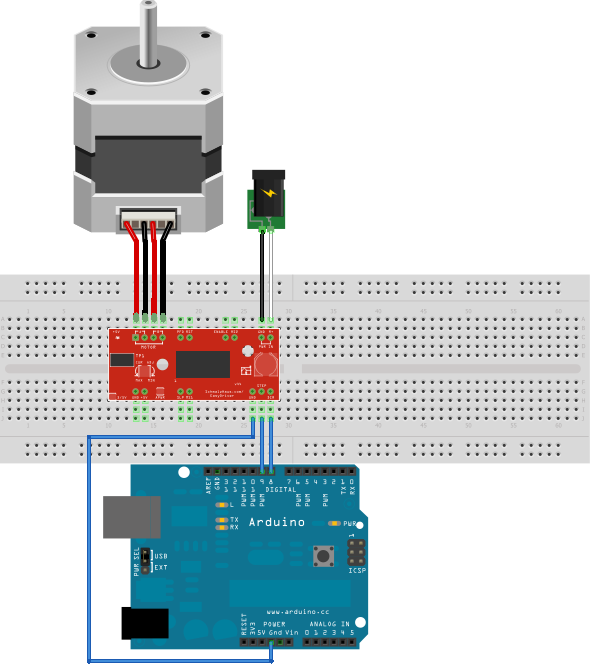

### Notes and measurements

Length of the rod = 29 cm
Length of the mounting piece = 5.1 cm
1 microstep = 1 write high
1600 microsteps per revolution
threads per inch = 13 (one thread is possible one revolution)

try and move ~5 centimeters (1.96850394 in)

1600 steps = 1 revolution = 1/13 inches = 0.195384615 cms
1 step = 0.00012211538437500001 cm = 0.122 micrometer

5 cm ~ 40944 microsteps

In [30]:
import pyfirmata
import time

In [31]:
def step(step_pin=9, dir_pin=8, direction=0):
    """
    Moves the Arduino one microstep.
    
    Inputs:
        step_pin (int): pin on arduino to control stepping
        dir_pin (int): pin on arduino to control direction
        direction (0 or 1): direction motor will move when stepped
    """
    board.digital[dir_pin].write(direction) # direction pin
    board.digital[step_pin].write(1)
    #time.sleep(.01) # lowest windows can get is 10ms, motor runs faster if we remove the time delay 
    board.digital[step_pin].write(0)
    #time.sleep(.01)
    return

In [32]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board = pyfirmata.Arduino('COM3') 

In [35]:
# Run the motor

board.digital[8].write(1) # stepping pin
board.digital[9].write(1) # direction pin

reps =  200*5 # 40944 # 100 
for i in range(reps+1):
    step(8,9, direction=1) # sipm motor (Direction: down=0, up=1)
    #step(10,11, direction=0) # LED motor
    #step(4,5)
    #time.sleep(0.01)

In [26]:
(1600*4)/32

(106.6 + 106.8)/2 - 6.925

99.77499999999999

LED MOTOR measurements
0 steps = 6.85, 7.00 mm = 

0 steps = 6.925 mm

1600*4 steps = 38.75, 38.85
= 38.8

1600*4 steps = 31.875 mm

-> 1 mm = 200 steps

------------------------------------
SIPM motor measurements
0 steps = 6.95 

1600*4 steps  = 106.95 mm

-----------------------------------

EasyDriver 1
Green,8 = step, blue,9 = dir

EasyDriver 2
Yellow,10 = step, orange,11 = dir

pins = 8,9,10

In [ ]:
for i in range(0,1000):
    board.digital[9].write(direction) # direction pin
    board.digital[8].write(1)
    time.sleep(.01) # lowest windows can get is 10ms, motor runs faster if we remove the time delay 
    board.digital[8].write(0)
    time.sleep(.01)